# Source localization with MNE/dSPM/sLORETA

The aim of this lecture is to teach you how to compute and apply
a linear inverse method such as MNE/dSPM/sLORETA on evoked/raw/epochs data.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mne

## Recap: going from raw to evoked

In [3]:
from mne.datasets import sample
data_path = sample.data_path()

raw_fname = data_path / 'MEG/sample/sample_audvis_filt-0-40_raw.fif'

raw = mne.io.read_raw_fif(raw_fname)

Opening raw data file /Users/mainak/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [4]:
events = mne.find_events(raw, stim_channel='STI 014')

319 events found
Event IDs: [ 1  2  3  4  5 32]


In [5]:
event_id = dict(aud_l=1)  # event trigger and conditions
tmin, tmax = -0.2, 0.5
raw.info['bads'] = ['MEG 2443', 'EEG 053']
picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=True, exclude='bads')
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, reject=reject, preload=True, verbose=False)
evoked = epochs.average()

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


## Math of Source estimation

To compute source estimates, one typically assumes:
    
$$M = GX + E$$

where $M \in \mathbb{R}^{C \times T}$ is the sensor data, $G \in \mathbb{R}^{C \times S}$ is the lead-field (or gain) matrix, $X \in \mathbb{R}^{S \times T}$ is the source time course (stc) and $E \in \mathbb{R}^{C \times T}$ is additive Gaussian noise with zero mean and identity covariance

However, noise $E$ does not have identity covariance because of correlation between channels.
Thus, the noise covariance is computed empirically and made to be identity by "whitening"(more on this later ...)

Thus, the ingredients needed for source estimation are:
    
- the gain matrix $G$, computed during the forward calculation, which needs:
     - *Trans*: the coordinate transformation between head and MEG device
     - *Source space*: specifying the mesh on which we estimate the source current amplitudes
     - *Boundary element model (BEM)*: specifying the tissue profile and conductivity
- noise covariance matrix $EE{^\top}/T$

## Compute noise covariance

In [6]:
noise_cov = mne.compute_covariance(epochs, tmax=0.,
                                   method=['shrunk', 'empirical'])
print(noise_cov.data.shape)

Computing rank from data with rank=None
    Using tolerance 2.8e-09 (2.2e-16 eps * 305 dim * 4.2e+04  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 3)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 305 -> 302
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 1705
log-likelihood on unseen data (descending order):
   shrunk: -1466.614
   empirical: -1574.608
selecting best estimator: shrunk
[done]
(305, 305)


Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.97  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.6e-13 (2.2e-16 eps * 203 dim * 3.5  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors


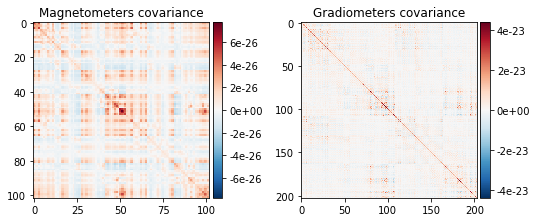

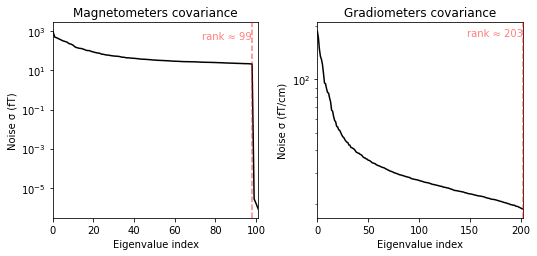

(<Figure size 547.2x266.4 with 4 Axes>, <Figure size 547.2x266.4 with 2 Axes>)

In [7]:
mne.viz.plot_cov(noise_cov, raw.info)

# Show whitening

We can verify that the standard deviation is 1

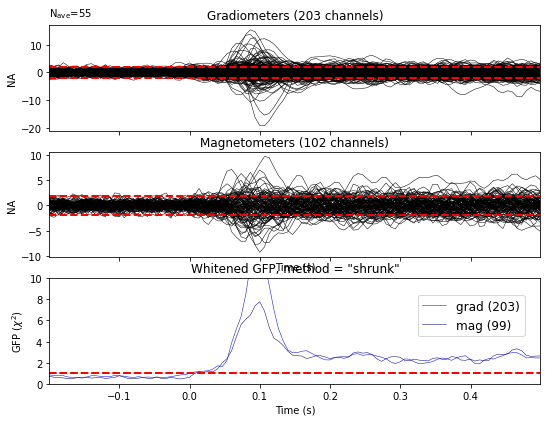

In [8]:
evoked.plot_white(noise_cov, verbose=False);

## Inverse modeling with MNE and dSPM on evoked and raw data

In [9]:
from mne.forward import read_forward_solution
from mne.minimum_norm import (make_inverse_operator, apply_inverse,
                              write_inverse_operator)

MNE/dSPM/sLORETA lead to linear inverse model that can be precomputed and applied to data in a later stage.

In [10]:
fname_fwd = data_path / 'MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd, verbose=False)

inverse_operator = make_inverse_operator(evoked.info, fwd, noise_cov,
                                         loose=0.2, depth=0.8, verbose=False)

## Compute inverse solution / Apply inverse operators

In [11]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stc = apply_inverse(evoked, inverse_operator, lambda2,
                    method=method, pick_ori=None, verbose=False)
print(stc)

<SourceEstimate | 7498 vertices, subject : sample, tmin : -199.79521315838787 (ms), tmax : 499.48803289596964 (ms), tstep : 6.659840438612929 (ms), data shape : (7498, 106), ~6.1 MB>


In [12]:
stc.data.shape

(7498, 106)

In [13]:
stc.save('fixed_ori', overwrite=True)

Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]


The STC (Source Time Courses) are defined on a source space formed by 7498 candidate
locations and for a duration spanning 106 time instants.

## Show the result

Using notebook 3d backend.



<IPython.core.display.Javascript object>


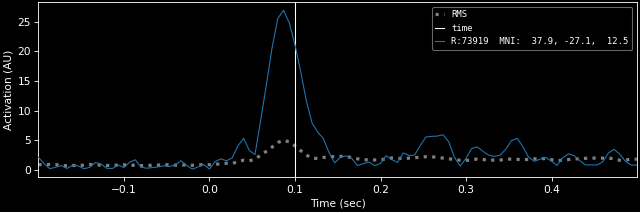

In [14]:
from mne.viz import set_3d_backend

set_3d_backend('notebook')

subjects_dir = data_path / 'subjects'
brain = stc.plot(surface='inflated', hemi='rh', subjects_dir=subjects_dir,
                 clim=dict(kind='value', lims=(8, 12, 15)), initial_time=0.1)
brain.show_view('lateral');

## Morphing data to an average brain for group studies

In [15]:
subjects_dir = data_path / 'subjects'
morph = mne.compute_source_morph(stc, subject_from='sample', subject_to='fsaverage',
                                 subjects_dir=subjects_dir)
stc_fsaverage = morph.apply(stc)

In [16]:
stc_fsaverage.save('fsaverage_dspm', overwrite=True)

Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]


<IPython.core.display.Javascript object>


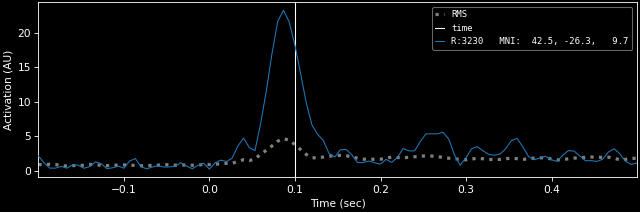

In [17]:
brain_fsaverage = stc_fsaverage.plot(surface='inflated', hemi='rh',
                                     subjects_dir=subjects_dir, initial_time=0.1,
                                     clim=dict(kind='value', lims=(8, 12, 15)))
brain_fsaverage.show_view('lateral')

### Solving the inverse problem on raw data or epochs using Freesurfer labels

In [18]:
fname_label = data_path / 'MEG/sample/labels/Aud-lh.label'
label = mne.read_label(fname_label)

Compute inverse solution during the first 15s:

In [19]:
from mne.minimum_norm import apply_inverse_raw, apply_inverse_epochs
start, stop = raw.time_as_index([0, 15])  # read the first 15s of data
stc = apply_inverse_raw(raw, inverse_operator, lambda2, method, label,
                        start, stop)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse to raw...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    combining the current components...
[done]


Plot the dSPM time courses in the label

Text(0, 0.5, 'dSPM value')

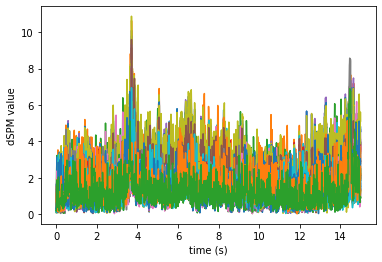

In [20]:
%matplotlib inline
plt.plot(stc.times, stc.data.T)
plt.xlabel('time (s)')
plt.ylabel('dSPM value')

And on epochs:

In [21]:
# Compute inverse solution and stcs for each epoch
# Use the same inverse operator as with evoked data (i.e., set nave)
# If you use a different nave, dSPM just scales by a factor sqrt(nave)

stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method, label,
                            pick_ori="normal", nave=evoked.nave)

stc_evoked = apply_inverse(evoked, inverse_operator, lambda2, method,
                           pick_ori="normal")

stc_evoked_label = stc_evoked.in_label(label)

# Average over label (not caring to align polarities here)
label_mean_evoked = np.mean(stc_evoked_label.data, axis=0)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 55
Processing epoch : 2 / 55
Processing epoch : 3 / 55
Processing epoch : 4 / 55
Processing epoch : 5 / 55
Processing epoch : 6 / 55
Processing epoch : 7 / 55
Processing epoch : 8 / 55
Processing epoch : 9 / 55
Processing epoch : 10 / 55
Processing epoch : 11 / 55
Processing epoch : 12 / 55
Processing epoch : 13 / 55
Processing epoch : 14 / 55
Processing epoch : 15 / 55
Processing epoch : 16 / 55
Processing epoch : 17 / 55
Processing epoch : 18 / 55
Processing epoch : 19 / 55
Processing epoch : 20 / 55
Processing epoch 

Mean across trials but not across vertices in label

In [22]:
mean_stc = np.sum(stcs) / len(stcs)

Take the mean across vertices in an ROI

In [23]:
flip = mne.label_sign_flip(label, inverse_operator['src'])

label_mean = np.mean(mean_stc.data, axis=0)
label_mean_flip = np.mean(flip[:, np.newaxis] * mean_stc.data, axis=0)

View activation time-series to illustrate the benefit of aligning/flipping

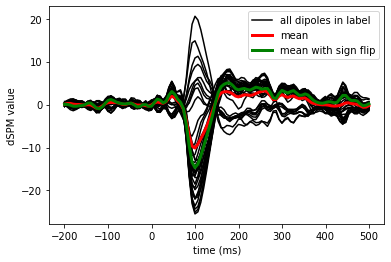

In [24]:
times = 1e3 * stcs[0].times  # times in ms

plt.figure()
h0 = plt.plot(times, mean_stc.data.T, 'k')
h1, = plt.plot(times, label_mean, 'r', linewidth=3)
h2, = plt.plot(times, label_mean_flip, 'g', linewidth=3)
plt.legend((h0[0], h1, h2), ('all dipoles in label', 'mean',
                             'mean with sign flip'))
plt.xlabel('time (ms)')
plt.ylabel('dSPM value')
plt.show()

Viewing single trial dSPM and average dSPM for unflipped pooling over label

Compare to (1) Inverse (dSPM) then average, (2) Evoked then dSPM

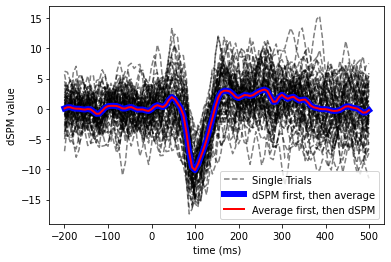

In [25]:
# Single trial
plt.figure()
for k, stc_trial in enumerate(stcs):
    plt.plot(times, np.mean(stc_trial.data, axis=0).T, 'k--',
             label='Single Trials' if k == 0 else '_nolegend_',
             alpha=0.5)

# Single trial inverse then average.. making linewidth large to not be masked
plt.plot(times, label_mean, 'b', linewidth=6,
         label='dSPM first, then average')

# Evoked and then inverse
plt.plot(times, label_mean_evoked, 'r', linewidth=2,
         label='Average first, then dSPM')

plt.xlabel('time (ms)')
plt.ylabel('dSPM value')
plt.legend()
plt.show()

## Exercises
- Run sLORETA on the same data and compare source localizations